# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt

In [3]:
# sklearn dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
# inballanced-learn dependencies
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import SMOTE

from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

from imblearn.combine import SMOTEENN

# Read the CSV and Perform Basic Data Cleaning

In [5]:
#Read CSV
file_path = Path('./Data/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,20000.0,20000.0,20000.0,60 months,17.19%,499.10,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,21225.0,21225.0,21225.0,60 months,14.74%,502.05,C,C2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000.0,5000.0,5000.0,36 months,17.97%,180.69,D,D1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,20000.0,20000.0,20000.0,36 months,8.19%,628.49,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,12000.0,12000.0,12000.0,60 months,15.57%,289.09,C,C3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115675 entries, 0 to 115674
Columns: 144 entries, id to settlement_term
dtypes: float64(117), object(27)
memory usage: 127.1+ MB


In [7]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [8]:
print(len(columns))

86


In [9]:
# Load the data
# file_path = Path('LoanStats_2019Q1.csv')
# df = pd.read_csv(file_path, skiprows=1)[:-2]
loans_df = df.loc[:, columns].copy()
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115675 entries, 0 to 115674
Data columns (total 86 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   115675 non-null  float64
 1   int_rate                    115675 non-null  object 
 2   installment                 115675 non-null  float64
 3   home_ownership              115675 non-null  object 
 4   annual_inc                  115675 non-null  float64
 5   verification_status         115675 non-null  object 
 6   issue_d                     115675 non-null  object 
 7   loan_status                 115675 non-null  object 
 8   pymnt_plan                  115675 non-null  object 
 9   dti                         115418 non-null  float64
 10  delinq_2yrs                 115675 non-null  float64
 11  inq_last_6mths              115675 non-null  float64
 12  open_acc                    115675 non-null  float64
 13  pub_rec       

In [10]:
# Drop the null columns where all values are null
loans_df = loans_df.dropna(axis='columns', how='all')
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115675 entries, 0 to 115674
Data columns (total 86 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   115675 non-null  float64
 1   int_rate                    115675 non-null  object 
 2   installment                 115675 non-null  float64
 3   home_ownership              115675 non-null  object 
 4   annual_inc                  115675 non-null  float64
 5   verification_status         115675 non-null  object 
 6   issue_d                     115675 non-null  object 
 7   loan_status                 115675 non-null  object 
 8   pymnt_plan                  115675 non-null  object 
 9   dti                         115418 non-null  float64
 10  delinq_2yrs                 115675 non-null  float64
 11  inq_last_6mths              115675 non-null  float64
 12  open_acc                    115675 non-null  float64
 13  pub_rec       

In [11]:
# Drop the null rows
loans_df = loans_df.dropna()
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82537 entries, 0 to 115673
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   82537 non-null  float64
 1   int_rate                    82537 non-null  object 
 2   installment                 82537 non-null  float64
 3   home_ownership              82537 non-null  object 
 4   annual_inc                  82537 non-null  float64
 5   verification_status         82537 non-null  object 
 6   issue_d                     82537 non-null  object 
 7   loan_status                 82537 non-null  object 
 8   pymnt_plan                  82537 non-null  object 
 9   dti                         82537 non-null  float64
 10  delinq_2yrs                 82537 non-null  float64
 11  inq_last_6mths              82537 non-null  float64
 12  open_acc                    82537 non-null  float64
 13  pub_rec                     82

In [12]:
loans_df['loan_status'].value_counts()

Current               68470
Issued                13720
In Grace Period         171
Late (16-30 days)        89
Late (31-120 days)       87
Name: loan_status, dtype: int64

In [13]:
# Remove the `Issued` loan status
issued_mask = loans_df['loan_status'] != 'Issued'
loans_df = loans_df.loc[issued_mask]
loans_df['loan_status'].value_counts()

Current               68470
In Grace Period         171
Late (16-30 days)        89
Late (31-120 days)       87
Name: loan_status, dtype: int64

In [14]:
# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
loans_df = loans_df.replace(x)
loans_df['loan_status'].value_counts()

low_risk              68470
In Grace Period         171
Late (16-30 days)        89
Late (31-120 days)       87
Name: loan_status, dtype: int64

In [15]:
x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
loans_df = loans_df.replace(x)
loans_df['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [16]:
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
93,10500.0,17.19%,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
99,25000.0,20.00%,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
132,20000.0,20.00%,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
133,10000.0,16.40%,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
140,22000.0,14.74%,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [17]:
# convert interest rate to numerical
loans_df['int_rate'] = loans_df['int_rate'].str.replace('%', '')
loans_df['int_rate'] = loans_df['int_rate'].astype('float') / 100
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
93,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
99,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
132,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
133,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
140,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [18]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68817 entries, 93 to 115673
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   68817 non-null  float64
 1   int_rate                    68817 non-null  float64
 2   installment                 68817 non-null  float64
 3   home_ownership              68817 non-null  object 
 4   annual_inc                  68817 non-null  float64
 5   verification_status         68817 non-null  object 
 6   issue_d                     68817 non-null  object 
 7   loan_status                 68817 non-null  object 
 8   pymnt_plan                  68817 non-null  object 
 9   dti                         68817 non-null  float64
 10  delinq_2yrs                 68817 non-null  float64
 11  inq_last_6mths              68817 non-null  float64
 12  open_acc                    68817 non-null  float64
 13  pub_rec                     6

In [19]:
loans_df.reset_index(inplace=True, drop=True)

loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


#### Create the training variables by converting the string values into numerical ones using the get_dummies() method

In [20]:
#what are our gategorical value columns
columns_obj = loans_df.select_dtypes(include='object').columns
print(len(columns_obj))

10


In [21]:
# get_dummies method in pandas
columns_obj

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type',
       'hardship_flag', 'debt_settlement_flag'],
      dtype='object')

In [22]:
#examine home_ownership
loans_df['home_ownership'].value_counts()

MORTGAGE    36219
RENT        24613
OWN          7346
ANY           639
Name: home_ownership, dtype: int64

In [23]:
# examine all the columns
for column in loans_df[columns_obj]:
    print(column,"\n",loans_df[column].value_counts())
    print("--------------------------------------------")

home_ownership 
 MORTGAGE    36219
RENT        24613
OWN          7346
ANY           639
Name: home_ownership, dtype: int64
--------------------------------------------
verification_status 
 Not Verified       32895
Source Verified    25737
Verified           10185
Name: verification_status, dtype: int64
--------------------------------------------
issue_d 
 Jan-2019    31041
Feb-2019    25579
Mar-2019    12197
Name: issue_d, dtype: int64
--------------------------------------------
loan_status 
 low_risk     68470
high_risk      347
Name: loan_status, dtype: int64
--------------------------------------------
pymnt_plan 
 n    68817
Name: pymnt_plan, dtype: int64
--------------------------------------------
initial_list_status 
 w    60292
f     8525
Name: initial_list_status, dtype: int64
--------------------------------------------
next_pymnt_d 
 May-2019    42449
Apr-2019    26368
Name: next_pymnt_d, dtype: int64
--------------------------------------------
application_type 
 Indivi

In [24]:
# drop columns that have just one value in value_counts()
loans_df = loans_df.drop(columns=['debt_settlement_flag','hardship_flag','pymnt_plan'])
loans_df.shape

(68817, 83)

In [25]:
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


In [81]:
# save our loans_Df as clean_loans_df csv file
clean_loans_df = loans_df

clean_loans_df.to_csv("./Data/clean_loans.csv", index=False)

In [82]:
clean_loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


In [28]:
# read in the csv file
df = pd.read_csv("./Data/clean_loans.csv")
df.head()

,Unnamed: 0,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


# Split the Data into Training and Testing

In [29]:
# Create our features
X = df.drop(columns='loan_status')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 83 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  68817 non-null  int64  
 1   loan_amnt                   68817 non-null  float64
 2   int_rate                    68817 non-null  float64
 3   installment                 68817 non-null  float64
 4   home_ownership              68817 non-null  object 
 5   annual_inc                  68817 non-null  float64
 6   verification_status         68817 non-null  object 
 7   issue_d                     68817 non-null  object 
 8   dti                         68817 non-null  float64
 9   delinq_2yrs                 68817 non-null  float64
 10  inq_last_6mths              68817 non-null  float64
 11  open_acc                    68817 non-null  float64
 12  pub_rec                     68817 non-null  float64
 13  revol_bal                   688

In [30]:
# Create our target
y = df['loan_status']
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [31]:
# this is our imballanced problem
print(347/68470)

0.005067912954578648


In [32]:
X.describe()

,Unnamed: 0,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,34408.000000,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,19865.901074,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,0.000000,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,17204.000000,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,34408.000000,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,51612.000000,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,68816.000000,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [33]:
X.shape

(68817, 83)

In [34]:
# Use get dummies to transform object dtypes into int
X_encoded = pd.get_dummies(X)
X_encoded.shape

(68817, 93)

In [35]:
# all our columns in pour features matrix (x) are numeric
X_encoded.describe()

,Unnamed: 0,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,34408.000000,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,...,0.148001,0.371696,0.451066,0.177238,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660
std,19865.901074,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,...,0.355104,0.483261,0.497603,0.381873,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637
min,0.000000,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17204.000000,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,34408.000000,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,51612.000000,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,68816.000000,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
# examine shape of X
X_encoded.shape

(68817, 93)

In [37]:
# examine shape of y
y.shape

(68817,)

### Scale and Normalize Data using Module 17.6.4

In [38]:
# Scale the X_encoded feature matrix
data_scaler = StandardScaler()

In [39]:
#fit and transform our X_encoded 
X_encoded_scaled = data_scaler.fit_transform(X_encoded)
X_encoded_scaled[:1]

array([[-1.73202564, -0.60109272,  0.91798436, -0.36555835, -0.1921948 ,
         0.27040056, -0.30314253, -0.65649151, -0.76165917, -0.37420432,
        -0.73252183, -0.8658573 , -0.58124513, -0.58081958, -0.50046544,
        -0.50029335, -0.3228639 , -0.89960419, -0.03227363,  0.        ,
         0.        , -0.17383528, -0.12011247,  0.        ,  0.        ,
        -0.00589695, -0.72692228,  1.67997825,  0.2392533 ,  1.19137226,
         1.35299632, -0.80895603, -0.13418715, -0.45717571, -0.16310175,
        -0.24864022, -0.83203994,  0.12422197, -1.04213361, -0.24758239,
        -0.59166015,  0.75578041,  0.37274923, -0.59052419, -0.80915288,
         1.04494582, -0.07820908, -0.00778953, -0.56994022, -0.7981628 ,
        -0.64845959, -0.66313947, -0.8249868 , -0.14674317, -1.10824038,
        -0.33490355, -1.13862411, -1.05103022, -1.27998521, -1.40011594,
         0.06599699, -1.11347944, -1.31043257, -1.0519437 , -0.75930693,
         0.        ,  0.        , -0.13347217,  0.4

In [40]:
# Check the balance of our target values
# y['loan_status'].value_counts()

In [41]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y, random_state = 1)

In [42]:
y_train.value_counts()

low_risk     51366
high_risk      246
Name: loan_status, dtype: int64

In [43]:
print(246/51366)

0.004789160144842892


In [44]:
# get a baseline of performance using logisticsRegression classifier to make predictions and evaluate the model's performance
# Calculate the accuracy score of the model.
# Generate a confusion matrix.
# Print out the 
# Classification report.ing logistics regression
# impallanced classification report.ing logistics regression

# model
# fit
# assess


In [45]:
# Instantiate a Logistic Regression Model
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier

LogisticRegression(random_state=1)

In [46]:
#fit our model with our data (training)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [47]:
# create predictions using predict() method
y_pred = classifier.predict(X_test)
y_pred

array(['low_risk', 'low_risk', 'low_risk', ..., 'low_risk', 'low_risk',
       'low_risk'], dtype=object)

In [48]:
#view the data
pd.DataFrame({"Prediction": y_pred, "Actual": y_test})
# .value_counts()

,Prediction,Actual
7034,low_risk,low_risk
38804,low_risk,low_risk
65533,low_risk,low_risk
37736,low_risk,low_risk
6390,low_risk,low_risk
...,...,...
31854,low_risk,low_risk
27835,low_risk,low_risk
3089,low_risk,low_risk
43343,low_risk,low_risk


In [49]:
# calculate model accuracy
accuracy_score(y_test, y_pred)

0.9948270851496658

In [50]:
#Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[   19    82]
 [    7 17097]]


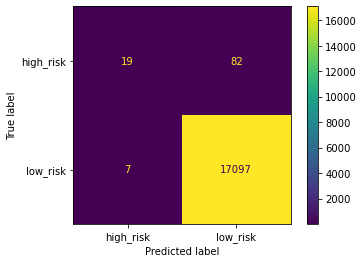

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= classifier.classes_)
disp.plot()

In [52]:
# View the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   high_risk       0.73      0.19      0.30       101
    low_risk       1.00      1.00      1.00     17104

    accuracy                           0.99     17205
   macro avg       0.86      0.59      0.65     17205
weighted avg       0.99      0.99      0.99     17205



In [53]:
# view the imballanced classification report
report = classification_report_imbalanced(y_test, y_pred)
print(report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.73      0.19      1.00      0.30      0.43      0.17       101
   low_risk       1.00      1.00      0.19      1.00      0.43      0.20     17104

avg / total       0.99      0.99      0.19      0.99      0.43      0.20     17205



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [54]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [55]:
# what is the "Balanced" or "Mix" between loan_status
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [56]:
# Train the Logistic Regression model using the resampled data
#from sklearn.linear_model import LogisticRegression

# Model
clf = LogisticRegression(solver='lbfgs', random_state=1)

# Fit
clf.fit(X_resampled, y_resampled)

# Predict using the predict method
y_pred = clf.predict(X_test)

In [57]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8398359714362456

In [58]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

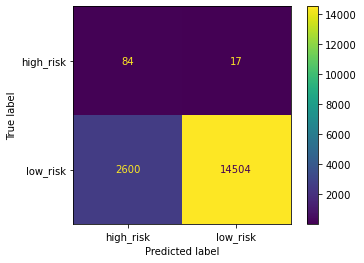

In [59]:
# Show confusion Metrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= clf.classes_)
disp.plot()

# save the image
plt.savefig("./Images/RandomOverSampler_confusion_matrix.png")
plt.show()

In [60]:
# Print the imbalanced classification report
# high_risk       0.81      0.21      1.00
print("RandomOverSampler")
print(classification_report_imbalanced(y_test, y_pred))

RandomOverSampler
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.83      0.85      0.06      0.84      0.70       101
   low_risk       1.00      0.85      0.83      0.92      0.84      0.71     17104

avg / total       0.99      0.85      0.83      0.91      0.84      0.71     17205



### SMOTE Oversampling

In [61]:
# Resample the training data with SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)

In [62]:
# Check the balance of the loan_status
Counter(y_resampled)

Counter({0:451, 1:451})

Counter({0: 451, 1: 451})

In [63]:
# clf = classifier replacing # model

# Model
clf = LogisticRegression(solver='lbfgs', random_state=1)

# Train/Fit
clf.fit(X_resampled, y_resampled)

# Predict
y_pred = clf.predict(X_test)

In [64]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8463155512230363

In [65]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print(cm)

[[   83    18]
 [ 2209 14895]]


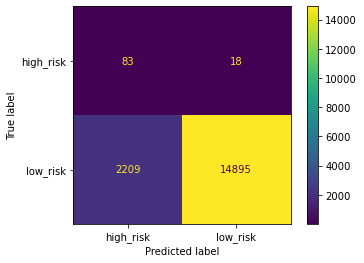

In [66]:
# Show confusion Metrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= clf.classes_)
disp.plot()

# save the image
plt.savefig("./Images/SMOTE_confusion_matrix.png")
plt.show()

In [67]:
# Print the imbalanced classification report
print("SMOTE")
print(classification_report_imbalanced(y_test, y_pred))

SMOTE
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.85      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.85      0.72     17104

avg / total       0.99      0.87      0.82      0.93      0.85      0.72     17205



In [68]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE

# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [69]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

In [70]:
# Train the Logistic Regression model using the resampled data
clf = LogisticRegression(solver='lbfgs', random_state=1)
clf.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [71]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8463155512230363

In [72]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print(cm)

[[   83    18]
 [ 2209 14895]]


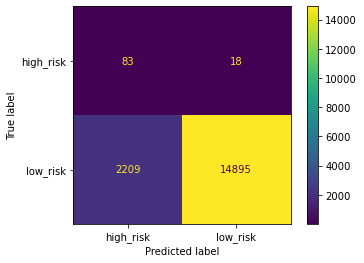

In [73]:
# Show confusion Metrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= clf.classes_)
disp.plot()

# save the image
plt.savefig("./Images/ClusterCentroids_confusion_matrix.png")
plt.show()

In [74]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.85      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.85      0.72     17104

avg / total       0.99      0.87      0.82      0.93      0.85      0.72     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [75]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train, y_train)
Counter(y_resampled)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [76]:
# Train the Logistic Regression model using the resampled data
# Model
clf = LogisticRegression(solver='lbfgs', random_state=1)

# Fit
clf.fit(X_resampled, y_resampled)

# Predict
y_pred = clf.predict(X_test)

In [77]:
# Calculated the balanced accuracy score
y_pred = clf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.8463155512230363

In [78]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[   83,    18],
       [ 2209, 14895]], dtype=int64)

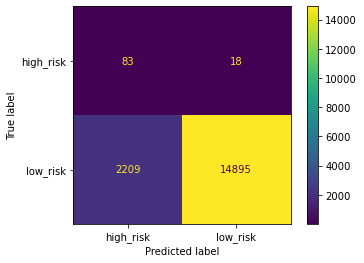

In [79]:
# Show confusion Metrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= clf.classes_)
disp.plot()

# save the image
plt.savefig("./Images/SMOTEENN_confusion_matrix.png")
plt.show()

In [80]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.85      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.85      0.72     17104

avg / total       0.99      0.87      0.82      0.93      0.85      0.72     17205

